In [136]:
# Khai báo các thư viện cần thiết
import gym
import numpy as np
from gym.spaces import Discrete
import random
from collections import deque
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
from collections import Counter

In [137]:
# Khai báo các hằng số sử dụng
class Action:
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
class Maze:
    WALL = -1
    UNEXPLORED = 0
    PATH = 1
    GOAL = 2
    AGENT_POSITION = 3
class Buff:
    NONE = 0
    SENRIGAN = 1
    TOU_NO_HIKARI = 2
    SLIME_SAN_ONEGAI = 3
    UNMEI_NO_MICHI = 4
    SLIME_STEP = 100
    TOU_NO_HIKARI_OBS = 8
    UNMEI_NO_MICHI_PATH = 1
class Debuff:
    NONE = 0
    WAAMU_HOURU = 1
    SHIN_NO_MEIRO = 2

In [138]:
# Khai báo tên model
def create_attention_data(local_size = 7, numbers_of_keys = 50000):
    keys = np.zeros((numbers_of_keys, local_size, local_size), dtype=int)
    values = np.zeros((numbers_of_keys, 4))
    relative_positions = np.zeros((numbers_of_keys, 2), dtype=int)
    step_remainings = np.zeros((numbers_of_keys), dtype=int)
    
    # Chuyển sang tensor
    keys_tensor = torch.tensor(keys, dtype=torch.int32)
    values_tensor = torch.tensor(values, dtype=torch.float32)
    relative_positions_tensor = torch.tensor(relative_positions, dtype=torch.int32)
    step_remainings_tensor = torch.tensor(step_remainings, dtype=torch.int32)

    print("Attention data created successfully.")
    return keys_tensor, values_tensor, relative_positions_tensor, step_remainings_tensor
    
while True:
    model_name = input("Enter model name: ")
    if model_name == "":
        print("Model name cannot be empty. Please enter a valid name.")
    else:
        if os.path.exists(model_name) == False:
            os.makedirs(model_name, exist_ok=True)
            keys, values, relative_positions, step_remainings = create_attention_data()
            keys_senrigan, values_senrigan, relative_positions_senrigan, step_remainings_senrigan = create_attention_data(11)
        break

In [139]:
# Môi trường Mê cung

class MazeEnv(gym.Env):
    # Môi trường mê cung
    # Maze: Mê cung được tạo ra ngẫu nhiên với các ô đường và tường
    # Với các ô đường được đánh dấu là 0 và các ô tường được đánh dấu là -1, ô đích được đánh dấu là 2
    # Discovered_maze: Mê cung đã được khám phá trong quá trình di chuyển của tác tử
    # Với các ô đường được đánh dấu là 0, các ô tường được đánh dấu là -5, đích được đánh dấu là 10, ô chưa được khám phá được đánh dấu là 1
    # Giá trị các ô đường giảm dần mỗi lần tác tử đi qua
    # Agent_position: Vị trí hiện tại của tác tử trong mê cung
    # Base_position: Vị trí ban đầu của tác tử trong mê cung
    # Goal_position: Vị trí đích trong mê cung
    # Buff: Biến để xác định xem tác tử có đang sử dụng buff senrigan hay không
    # Debuff: Biến để xác định xem tác tử có đang bị debuff shin no meiro hay không

    def __init__(self, maze_size, local_obs_size = 3, max_steps = 15, path_percent = 70):
        """
        Khởi tạo môi trường Mê cung.

        Args:
        - maze_size (int): Kích thước của mê cung (ví dụ: 50x50).
        - max_steps (int): Số bước tối đa cho mỗi tập.
        - path_percent (int): Tỷ lệ phần trăm ô đường trong mê cung (0-100).
        """
        # Đặt các thông số của môi trường
        super(MazeEnv, self).__init__()  # Kế thừa từ gym.Env
        
        self.maze_size = maze_size
        self.max_steps = max_steps
        self.path_percent = path_percent
        self.local_obs_size = local_obs_size
        
        self.maze = np.ones((maze_size, maze_size), dtype=int) * Maze.UNEXPLORED # Tạo mê cung với tất cả ô là chưa khám phá
        self.base_position = (maze_size // 6 - 1, maze_size // 6 - 1)  # Vị trí bắt đầu của tác tử
        self.goal_position = (maze_size * 5 // 6, maze_size * 5 // 6)  # Đích cố định tại giữa khu vực đích
        self.senrigan_buff = False
        self.shin_no_meiro_debuff = False

        # Định nghĩa action_space (0: lên, 1: xuống, 2: trái, 3: phải)
        self.action_space = Discrete(4)

    # Các phương thức liên quan đến tái tạo mê cung
    def reset(self, buff = Buff.NONE, debuff = Debuff.NONE):
        self.agent_position = self.base_position
        return self.regenerate_maze(buff, debuff)
    
    def agent_position_format(self):
        x, y = self.agent_position[0] - self.goal_position[0], self.agent_position[1] - self.goal_position[1]
        x = max(min(x, self.local_obs_size), -self.local_obs_size)
        y = max(min(y, self.local_obs_size), -self.local_obs_size)
        return x, y
    
    def regenerate_maze(self, buff = Buff.NONE, debuff = Debuff.NONE):
        # Kích hoạt buff
        if buff == Buff.SENRIGAN:
            self.senrigan_buff = True
        else:
            self.senrigan_buff = False
        if buff == Buff.UNMEI_NO_MICHI:
            adder = Buff.UNMEI_NO_MICHI_PATH
        else:
            adder = 0
        # Kích hoạt debuff
        if debuff == Debuff.WAAMU_HOURU:
            self.agent_position = (random.randint(self.maze_size // 3, self.maze_size), random.randint(self.maze_size // 3, self.maze_size))
        if debuff == Debuff.SHIN_NO_MEIRO:
            self.shin_no_meiro_debuff = True
        else:
            self.shin_no_meiro_debuff = False
        # Tạo mê cung mới
        self.generate_maze(adder)
        self.create_discovered_maze()

        # Kích hoạt buff
        if buff == Buff.SLIME_SAN_ONEGAI:
            self.bfs(self.agent_position, Buff.SLIME_STEP)
        if buff == Buff.TOU_NO_HIKARI:
            local_obs_size = Buff.TOU_NO_HIKARI_OBS
        else:
            local_obs_size = 3
        self.discover_maze(local_obs_size)

        return_discovered_maze = self.discovered_maze.copy()
        return self.get_observation(), return_discovered_maze, self.agent_position, self.agent_position_format()

    def generate_maze(self, adder = 0):
        if self.agent_position[0] >= self.maze_size * 2 // 3 and self.agent_position[1] >= self.maze_size * 2 // 3:
            number_of_path = 1 + adder
        else:
            number_of_path = 2 + adder

        total_cells = self.maze_size * self.maze_size
        num_paths = int(total_cells * self.path_percent / 100)
        num_walls = total_cells - num_paths
        maze_values = [Maze.PATH] * num_paths + [Maze.WALL] * num_walls

        while True:  # Sử dụng vòng lặp để tạo lại mê cung nếu không hợp lệ
            random.shuffle(maze_values)  # Xáo trộn các giá trị
            
            # Điền vào mê cung
            self.maze = np.array(maze_values).reshape(self.maze_size, self.maze_size)
            
            # Đặt điểm bắt đầu và đích
            self.maze[self.agent_position] = Maze.PATH # Đặt vị trí tác tử là đường 
            self.maze[self.goal_position] = Maze.GOAL # Đặt vị trí đích

            # Kiểm tra tính hợp lệ
            if self.validate_maze(number_of_path):
                break  # Nếu mê cung hợp lệ, thoát vòng lặp

    def validate_maze(self, number_of_path = 0):
        d = 0
        temp_maze = self.maze.copy()  # Tạo bản sao của mê cung
        for _ in range(number_of_path):
            path = self.shortest_path(temp_maze)
            if path is None:  # Nếu không tìm thấy đường đi
                break
            d += 1  # Tăng số lượng đường đi hợp lệ
            for x, y in path:
                temp_maze[x, y] = Maze.WALL 
                # Đánh dấu các ô đã đi qua là tường
            temp_maze[self.agent_position] = Maze.PATH  # Đặt lại vị trí tác tử là đường
            temp_maze[self.goal_position] = Maze.GOAL  # Đặt lại vị trí đích là đường

        if self.shin_no_meiro_debuff:
            return d==0
        if d == number_of_path:
            return True
        else:
            return False
        
    def shortest_path(self, maze):
        # Hàng đợi để BFS
        queue = deque([(self.agent_position, [self.agent_position])])  # Lưu trữ (vị trí hiện tại, đường đi)
        visited = set()  # Tập hợp các điểm đã thăm
        visited.add(self.agent_position)
        
        while queue:
            current, path = queue.popleft()

            # Kiểm tra nếu đã đến điểm end
            if current == self.goal_position:
                return path  # Trả về đường đi ngắn nhất
            
            # Lấy các điểm lân cận
            for neighbor in self.get_neighbors(current[0], current[1]):
                if neighbor not in visited and maze[neighbor] != Maze.WALL: 
                    visited.add(neighbor)
                    queue.append((neighbor, path + [neighbor]))
        
        return None  # Không tìm thấy đường đi

    def get_neighbors(self, x, y):
        """
        Lấy danh sách các ô lân cận.
        """
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.maze_size and 0 <= ny < self.maze_size:
                neighbors.append((nx, ny))
        return neighbors
    
    # Các phương thức liên quan đến mê cung được khám phá
    def create_discovered_maze(self):
        self.discovered_maze = np.zeros((self.maze_size + 10, self.maze_size + 10), dtype=int)  # Tạo mê cung đã khám phá
        self.discovered_maze.fill(Maze.UNEXPLORED)  # Đánh dấu tất cả ô là chưa khám phá (1)
        self.discovered_maze[0 : 5, :] = 5 * Maze.WALL
        self.discovered_maze[:, 0 : 5] = 5 * Maze.WALL
        self.discovered_maze[self.maze_size + 5 : self.maze_size + 10, :] = 5 * Maze.WALL
        self.discovered_maze[:, self.maze_size + 5 : self.maze_size + 10] = 5 * Maze.WALL
        self.discovered_maze[self.goal_position[0] + 5, self.goal_position[1] + 5] = 10  # Đích được đánh dấu là 10
        
    def discover_maze(self, local_obs_size = 3):
        x, y = self.agent_position
        if self.senrigan_buff:
            half_size = max(5, local_obs_size)  
        else:
            half_size = max(3, local_obs_size)  

        # Xác định giới hạn của vùng quan sát trong mê cung
        min_x = max(0, x - half_size)
        max_x = min(self.maze_size, x + half_size + 1)
        min_y = max(0, y - half_size)
        max_y = min(self.maze_size, y + half_size + 1)

        # Điền dữ liệu từ mê cung vào vùng khám phá
        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                if self.discovered_maze[x + 5, y + 5] == Maze.UNEXPLORED:
                    if self.maze[x, y] == Maze.PATH:
                        self.discovered_maze[x + 5, y + 5] = 2 * Maze.PATH
                    else:
                        self.discovered_maze[x + 5, y + 5] = 5 * self.maze[x, y]
        
    # Phương thức chính để thực hiện hành động trong môi trường
    def step(self, action, take_action = True):
        """
        Thực hiện hành động và cập nhật trạng thái của môi trường.
    
        Args:
        - action (int): Hành động 
    
        Returns:
        - local_obs (np.array): Quan sát hiện tại của tác tử
        - global_obs (np.array): Mê cung đã khám phá
        - reward (float): Phần thưởng
        - done (bool): Trạng thái kết thúc
        """
        # Lưu lại trạng thái nếu không thực hiện hành động
        if not take_action:
            saved_position = self.agent_position
            saved_discovered_maze = self.discovered_maze.copy()

        # Lấy vị trí hiện tại của tác tử
        x, y = self.agent_position
    
        # Xác định vị trí mới dựa trên hành động
        if action == Action.UP:  # Lên
            new_x, new_y = x - 1, y
        elif action == Action.DOWN:  # Xuống
            new_x, new_y = x + 1, y
        elif action == Action.LEFT:  # Trái
            new_x, new_y = x, y - 1
        elif action == Action.RIGHT:  # Phải
            new_x, new_y = x, y + 1
    
        # Khởi tạo biến phần thưởng
        reward = 0
        done = False
        
        # Cập nhật vị trí tác tử
        if self.valid_check((new_x, new_y)) and self.discovered_maze[new_x + 5, new_y + 5] != 5 * Maze.WALL:  # Nếu vị trí mới hợp lệ và không phải là tường
            # Nếu vị trí mới hợp lệ, cập nhật vị trí tác tử
            self.agent_position = (new_x, new_y)
            self.discover_maze()

        if self.discovered_maze[new_x + 5, new_y + 5] == 5 * Maze.WALL:
            reward -= 2 * self.maze_size  # Phạt lớn khi va chạm với tường
        elif self.agent_position == self.goal_position:
            reward += 3 * self.maze_size  # Thưởng lớn khi đến đích
            done = True
        else:
            # Tính khoảng cách Manhattan từ vị trí hiện tại tới đích
            current_distance = abs(self.agent_position[0] - self.goal_position[0]) + abs(self.agent_position[1] - self.goal_position[1])
            
            # Tính khoảng cách trước đó
            previous_distance = abs(x - self.goal_position[0]) + abs(y - self.goal_position[1])

            # Tính khoảng cách đã đi được
            moved_distance = 1 + abs(new_x - self.agent_position[0]) + abs(new_y - self.agent_position[1])

            # Tăng thưởng nếu đến gần đích hơn
            if self.discovered_maze[new_x + 5, new_y + 5] == 2 * Maze.PATH:  # Nếu ô chưa được khám phá
                if current_distance < previous_distance:
                    reward += 2 * self.maze_size // current_distance  # Thưởng khi di chuyển đến gần đích hơn
                else:
                    reward -= 2 * self.maze_size // moved_distance # Phạt nếu tác tử đi xa hơn
                self.discovered_maze[new_x + 5, new_y + 5] = -1  
            else:
                # Phạt khi đi vào ô đã khám phá
                reward += self.discovered_maze[new_x + 5, new_y + 5] * self.maze_size // current_distance + self.discovered_maze[new_x + 5, new_y + 5] * self.maze_size // moved_distance
                # Giảm giá trị ô đã khám phá
                self.discovered_maze[new_x + 5, new_y + 5] -= 1
        
        # Tạo quan sát hiện tại
        local_obs = self.get_observation()
 
        #Tạo quan sát toàn mê cung
        return_discovered_maze = self.discovered_maze.copy()
        
        # Tạo kết quả trả về vị trí tác tử
        return_agent_position = self.agent_position

        # Tạo kết quả trả về vị trí tác tử đã được định dạng
        return_agent_position_format = self.agent_position_format()

        # Trả lại các giá trị đã lưu nếu không thực hiện hành động
        if not take_action:
            self.agent_position = saved_position
            self.discovered_maze = saved_discovered_maze.copy()
        return local_obs, return_discovered_maze, return_agent_position, return_agent_position_format, reward, done

    # Xuất dữ liệu mê cung
    def render(self):
        render_maze = np.zeros((self.maze_size, self.maze_size), dtype = int) 
        for i in range(self.maze_size):
            for j in range(self.maze_size):
                if self.maze[i][j] == Maze.WALL:
                    render_maze[i][j] = 1
                    continue
                if self.maze[i][j] == Maze.GOAL:
                    render_maze[i][j] = 10
                    continue
        print(render_maze)
    
    # Phương thức để lấy quan sát hiện tại của tác tử
    def get_observation(self):
        x, y = self.agent_position
        observation = np.zeros((2 * self.local_obs_size + 1, 2*self.local_obs_size + 1), dtype = int)
        observation[:, :] = self.discovered_maze[x + 5 - self.local_obs_size: x + 6 + self.local_obs_size, y + 5 - self.local_obs_size : y + 6 + self.local_obs_size]
        return observation

    def bfs(self, position, step):
        """
        Thuật toán BFS (Breadth-First Search)
    
        Args:
        - position: Đỉnh bắt đầu tìm kiếm.
        - step: số bược di chuyển
    
        """
        # Tập các đỉnh đã duyệt
        visited = set()
        visited_counter = 0
    
        # Hàng đợi (FIFO) để quản lý các đỉnh
        queue = deque([position])
    
        # Bắt đầu duyệt đồ thị
        while queue:
            # Lấy một đỉnh từ hàng đợi
            current = queue.popleft()
            x,y = current
            
            # Kiểm tra nếu đỉnh chưa được duyệt
            if current not in visited:
                visited.add(current)
                visited_counter += 1
                if self.discovered_maze[x + 5, y + 5] == Maze.UNEXPLORED:
                    if self.maze[x, y] == Maze.PATH:
                        self.discovered_maze[x + 5, y + 5] = 2 * Maze.PATH
                    else:
                        self.discovered_maze[5 + x, 5 + y] = 5 * self.maze[x, y]
                    
                # Nếu đã duyệt đủ số bước, dừng lại
                if visited_counter >= step:
                    break
                neighbors = self.get_neighbors(x, y)
                for nx, ny in neighbors:
                    if self.maze[nx, ny] != Maze.WALL and (nx, ny) not in visited:  # Chỉ đi qua đường
                        queue.append((nx, ny))
    
    # Phương thức để kiểm tra tính hợp lệ của một vị trí
    def valid_check(self, p1):
        if 0 <= p1[0] < self.maze_size and 0 <= p1[1] < self.maze_size and self.maze[p1] != Maze.WALL:
            return True
        return False
    
    def light_cone(self, step_remaining):
        """
        Tạo hình nón ánh sáng từ vị trí hiện tại của tác tử.
    
        Args:
        - step_remaining: Số bước còn lại để di chuyển.
    
        Returns:
        - light_cone: Hình nón ánh sáng.
        """
        x, y = self.agent_position
        light_cone = np.zeros((self.maze_size, self.maze_size), dtype=int)
        
        # Tạo hình nón ánh sáng
        for i in range(self.maze_size):
            for j in range(self.maze_size):
                dx = abs(x - i)
                dy = abs(y - j)
                if dx + dy <= step_remaining:
                    light_cone[i, j] = self.maze[i, j]
                
        return light_cone


In [140]:
# Mạng Nơ ron 
class AttentionBlock(nn.Module):
    def __init__(self):
        super(AttentionBlock, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def format(self, x):
        return F.relu(-x / 5)
    
    def forward(self, queries, relative_position, step_remaining, keys, values, relative_positions, step_remainings):
        x_queries = self.format(queries).expand(queries.size(0), keys.size(0), queries.size(2), queries.size(3))
        x_keys = keys.unsqueeze(0).expand(queries.size(0), keys.size(0), keys.size(1), keys.size(2))
        x_values = values.unsqueeze(0).expand(queries.size(0), keys.size(0), values.size(1))
        x_step_remainings = step_remainings.unsqueeze(0).expand(queries.size(0), keys.size(0))
        x_step_remaining = step_remaining.unsqueeze(1).expand(queries.size(0), keys.size(0))
        x_relative_positions = relative_positions.unsqueeze(0).expand(queries.size(0), keys.size(0), relative_positions.size(1))
        x_relative_position = relative_position.unsqueeze(1).expand(queries.size(0), keys.size(0), relative_position.size(1))
        x_distance = torch.sum(torch.abs(x_relative_positions - x_relative_position), dim = -1)
        simularity = self.calculate_similarity(x_queries, x_keys) - torch.abs(x_step_remainings - x_step_remaining) - x_distance 
        attention_weights = self.softmax(simularity)
        attention_weights = attention_weights.unsqueeze(2).expand(queries.size(0), keys.size(0), values.size(1))
        output = (attention_weights * x_values).sum(dim = (1))
        return output, self.softmax(simularity)
    
    def calculate_similarity(self, queries, keys):
        similarity = (queries * keys).sum(dim = (-2, -1))
        return similarity
    
class MazeNetCombined(nn.Module):
    def __init__(self, keys, values, relative_positions, step_remainings):
        super(MazeNetCombined, self).__init__()
        self.keys = keys
        self.values = values
        self.relative_positions = relative_positions
        self.step_remainings = step_remainings

        # Quan sát cục bộ
        self.conv1_local = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2_local = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3_local = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4_local = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Quan sát toàn cục
        self.conv1_global = nn.Conv2d(1, 32, kernel_size=2, stride=2, padding=0)
        self.conv2_global = nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0)

        # Xử lý vị trí
        self.fc_position = nn.Linear(2, 32)  # Vị trí hiện tại

        # Cơ chế attention ánh xạ đến các trường hợp đặc biệt
        self.attention_block = AttentionBlock()

        # Tầng Fully Connected cuối cùng
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.LazyLinear(128) 
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout trước tầng FC3
        self.fc3 = nn.LazyLinear(4)  # Đầu ra cho 4 hành động (lên, xuống, trái, phải)
    
    def forward(self, local_obs, global_obs, position, relative_position, step_remaining):
        # Xử lý local_obs
        x_local = F.relu(self.conv1_local(local_obs))
        x_local = F.relu(self.conv2_local(x_local))
        x_local = F.relu(self.conv3_local(x_local))
        x_local = F.relu(self.conv4_local(x_local))
        x_local = x_local.view(x_local.size(0), -1)
        
        # Xử lý global_obs
        x_global = F.relu(self.conv1_global(global_obs))
        x_global = F.relu(self.conv2_global(x_global))
        x_global = x_global.view(x_global.size(0), -1)

        # Xử lý vị trí hiện tại
        x_position = F.relu(self.fc_position(position))
        
        # Kết hợp tất cả
        x = torch.cat((x_local, x_global, x_position), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)  # Dropout trước FC3
        x = self.fc3(x)

        # Tính toán attention
        attention_output, attention_weights = self.attention_block(local_obs, relative_position, step_remaining, self.keys, self.values, self.relative_positions, self.step_remainings)
        return x, attention_output, attention_weights

    def update_attention_data(self, keys, values, relative_positions, step_remainings):
        self.keys = keys
        self.values = values
        self.relative_positions = relative_positions
        self.step_remainings = step_remainings

In [141]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity, path, save_prob=0.1):
        """
        Khởi tạo Replay Buffer.
        Args:
            capacity (int): Sức chứa của buffer chính.
            path (str): Đường dẫn để load/lưu buffer (saved_buffer).
            save_prob (float): Xác suất lưu trải nghiệm mới vào saved_buffer.
        """
        self.capacity = capacity
        self.buffer = []
        self.saved_buffer = []  # Buffer lưu từ tệp
        self.path = path
        self.save_prob = save_prob
        
        # Tải replay buffer đã lưu nếu tồn tại
        self._load_saved_buffer()

    def _load_saved_buffer(self):
        """Tải saved_buffer từ tệp."""
        try:
            with open(self.path, 'rb') as f:
                self.saved_buffer = pickle.load(f)
            with open(self.path, 'rb') as f:
                self.buffer = pickle.load(f)
            print(f"Saved buffer loaded successfully from {self.path}.")
        except FileNotFoundError:
            print(f"No saved buffer found at {self.path}. Starting with an empty saved buffer.")
        except Exception as e:
            print(f"Error loading saved buffer: {e}. Starting with an empty saved buffer.")

    def save_saved_buffer(self):
        """Lưu saved_buffer vào tệp tại path."""
        try:
            with open(self.path, 'wb') as f:
                pickle.dump(self.saved_buffer, f)
            print(f"Saved buffer successfully saved to {self.path}.")
        except Exception as e:
            print(f"Error saving saved buffer: {e}.")

    def push(self, experience):
        """Thêm một trải nghiệm vào buffer chính và có xác suất thêm vào saved_buffer."""
        self.buffer.append(experience)
        
        # Với xác suất save_prob, thêm trải nghiệm vào saved_buffer
        if np.random.rand() < self.save_prob:
            if len(self.saved_buffer) >= self.capacity:
                # Nếu saved_buffer đã đầy, xóa trải nghiệm cũ nhất
                self.saved_buffer.pop(0)
            self.saved_buffer.append(experience)

    def sample(self, batch_size):
        """Trích xuất batch mẫu từ buffer chính."""
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        # Tách dữ liệu thành các phần riêng biệt
        local_obs, global_obs, position, relative_position, step_remaining, actions, rewards, next_local_obs, next_global_obs, next_position, next_relative_position, next_step_remaining, dones = zip(*batch)
        return (np.array(local_obs), 
                np.array(global_obs), 
                np.array(position), 
                np.array(relative_position),
                np.array(step_remaining),
                np.array(actions), 
                np.array(rewards), 
                np.array(next_local_obs), 
                np.array(next_global_obs), 
                np.array(next_position), 
                np.array(next_relative_position),
                np.array(next_step_remaining),
                np.array(dones))

    def __len__(self):
        return len(self.buffer)

In [142]:
# Cập nhật model
def update_model(policy_net, target_net, replay_buffer, optimizer, batch_size, gamma, device):
    """
    Cập nhật mô hình chính (policy network) cho mạng có đầu vào đa dạng (local_obs, global_obs, position).

    Args:
    - policy_net (nn.Module): Mạng chính dự đoán giá trị Q(s, a).
    - target_net (nn.Module): Mạng mục tiêu dùng để tính Q_target.
    - replay_buffer (ReplayBuffer): Bộ nhớ hồi tiếp chứa các trải nghiệm.
    - optimizer (torch.optim.Optimizer): Trình tối ưu hóa (Adam, SGD, ...).
    - batch_size (int): Kích thước batch mẫu từ replay buffer.
    - gamma (float): Hệ số chiết khấu (discount factor).
    - device (torch.device): Thiết bị thực thi (CPU hoặc GPU).

    Returns:
    - loss (float): Giá trị mất mát (loss) sau khi cập nhật.
    """
    # Kiểm tra nếu replay buffer chưa đủ dữ liệu
    if len(replay_buffer) < batch_size:
        return None

    # 1. Lấy mẫu từ replay buffer
    batch = replay_buffer.sample(batch_size)
    (local_obs, global_obs, position, relative_position, step_remaining, actions, rewards, 
     next_local_obs, next_global_obs, next_position, next_relative_position, next_step_remaining, dones) = batch

    # 2. Chuyển đổi dữ liệu sang Tensor và đưa vào thiết bị (CPU/GPU)
    local_obs = torch.tensor(local_obs, dtype=torch.float32).to(device).unsqueeze(1)  # Thêm chiều kênh cho CNN
    global_obs = torch.tensor(global_obs, dtype=torch.float32).to(device).unsqueeze(1)  # Thêm chiều kênh
    position = torch.tensor(position, dtype=torch.float32).to(device)  
    relative_position = torch.tensor(relative_position, dtype=torch.float32).to(device)
    step_remaining = torch.tensor(step_remaining, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_local_obs = torch.tensor(next_local_obs, dtype=torch.float32).to(device).unsqueeze(1)  # Thêm chiều kênh
    next_global_obs = torch.tensor(next_global_obs, dtype=torch.float32).to(device).unsqueeze(1)  # Thêm chiều kênh
    next_position = torch.tensor(next_position, dtype=torch.float32).to(device)
    next_relative_position = torch.tensor(next_relative_position, dtype=torch.float32).to(device)
    next_step_remaining = torch.tensor(next_step_remaining, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # 3. Dự đoán Q(s, a) từ policy_net
    q_values, _, _ = policy_net(local_obs, global_obs, position, relative_position, step_remaining)  # Đầu ra: (batch_size, num_actions)
    q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Lấy giá trị Q(s, a) cho hành động đã thực hiện

    # 4. Tính toán Q_target bằng target_net
    with torch.no_grad():
        next_q_values, _, _ = target_net(next_local_obs, next_global_obs, next_position, next_relative_position, next_step_remaining)  # Dự đoán Q(s', a') từ target_net
        max_next_q_values = next_q_values.max(1)[0]  # Lấy giá trị lớn nhất Q(s', a')
        q_targets = rewards + gamma * max_next_q_values * (1 - dones)  # Hàm Bellman

    # 5. Tính hàm mất mát   
    loss = F.mse_loss(q_values, q_targets)

    # 6. Tối ưu hóa mô hình
    optimizer.zero_grad()  # Xóa gradient cũ
    loss.backward()  # Lan truyền ngược (backpropagation)
    optimizer.step()  # Cập nhật trọng số

    return loss.item()


In [143]:
# Chọn hành động
def select_action(env, policy_net, local_obs, global_obs, position, relative_position, step_remaining, device, total_attention_weight):
    """
    Chọn hành động dựa trên chiến lược Boltzmann Exploration.

    Args:
    - policy_net (nn.Module): Mạng chính để dự đoán giá trị Q(s, a).
    - local_obs (np.array): Quan sát cục bộ (ví dụ: 11x11).
    - global_obs (np.array): Quan sát toàn bộ mê cung (ví dụ: 50x50).
    - position (list or np.array): Vị trí hiện tại của tác tử (dx, dy).
    - device (torch.device): Thiết bị thực thi (CPU hoặc GPU).

    Returns:
    - action (int): Hành động được chọn (0, 1, 2, 3).
    """
    p1 = (position[0] - 1, position[1])
    p2 = (position[0] + 1, position[1])
    p3 = (position[0], position[1] - 1)
    p4 = (position[0], position[1] + 1)

    # Loại bỏ các hành động không hợp lệ (nếu cần)
    valid_actions = []
    if env.valid_check(p1): valid_actions.append(Action.UP)  # Lên
    if env.valid_check(p2): valid_actions.append(Action.DOWN)  # Xuống
    if env.valid_check(p3): valid_actions.append(Action.LEFT)  # Trái
    if env.valid_check(p4): valid_actions.append(Action.RIGHT)  # Phải

    # Chuyển đổi các quan sát thành Tensor để đưa vào mạng
    local_obs_tensor = torch.tensor(local_obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    global_obs_tensor = torch.tensor(global_obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    position_tensor = torch.tensor(position, dtype=torch.float32).unsqueeze(0).to(device)
    relative_position_tensor = torch.tensor(relative_position, dtype=torch.float32).unsqueeze(0).to(device)
    step_remaining_tensor = torch.tensor(step_remaining, dtype=torch.float32).unsqueeze(0).to(device)

    # Dự đoán giá trị Q(s, a) cho tất cả các hành động
    q_values, att_output, att_weight = policy_net(local_obs_tensor, global_obs_tensor, position_tensor, relative_position_tensor, step_remaining_tensor)  # Đầu ra: (1, num_actions)
    q_values = q_values + att_output * env.maze_size * 0.75  # Thêm đầu ra của attention vào giá trị Q
    att_weight = att_weight.squeeze(0)
    total_attention_weight += att_weight
    valid_q_values = q_values.squeeze()[valid_actions]  # Chỉ giữ Q của các hành động hợp lệ
    selected_index = valid_q_values.argmax().item()  # Chọn hành động có giá trị Q lớn nhất
    action = valid_actions[selected_index]
    
    return action

In [144]:
# Đồng bộ với mạng mục tiêu
def sync_target_network(q_network, target_network):
    target_network.load_state_dict(q_network.state_dict())

In [145]:
# Lưu, tải trọng số của mô hình

# Lưu trọng số của mô hình
def save_model(model, path):
    torch.save(model, path)
    print(f"Model saved to: {path}")
# Tải trọng số của mô hình
def load_model(path, device = "cuda"):
    policy_model = torch.load(path, map_location=device, weights_only=False)  # Tải mô hình từ file
    target_model = policy_model
    target_model.eval() # Đặt target_model ở chế độ đánh giá
    print(F"Model loaded from: {path}")
    return policy_model, target_model

In [146]:
# Khởi tạo các siêu tham số

# Thiết bị thực thi (CPU hoặc GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Chuyển attention_data sang device
attention_data = torch.tensor([0, 0], dtype=torch.float32).to(device)
senrigan_attention_data = torch.tensor([0, 0], dtype=torch.float32).to(device)

# Hyperparameters
gamma = 0.8  # Hệ số chiết khấu (discount factor)
learning_rate = 1e-3  # Learning rate cho optimizer
weight_decay = 1e-3 # weight decay cho optimizer
batch_size = 64  # Kích thước batch khi lấy mẫu từ replay buffer
target_update_frequency = 100  # Số vòng lặp huấn luyện trước khi đồng bộ target_net với policy_net
max_episodes = 10000  # Số lượng tập (episodes) tối đa
replay_buffer_capacity = 20000  # Dung lượng bộ nhớ replay buffer

# Thông tin về môi trường
maze_size = 30 # Kích thước mê cung (30x30)
max_steps = 15  # Số bước tối đa trong mỗi tập (episode)
path_percent = 70  # Tỷ lệ phần trăm ô đường đi trong mê cung (70% đường đi, 30% tường)
buff = Buff.TOU_NO_HIKARI  # Buff cho tác tử (nếu có)
if buff == Buff.SENRIGAN:
    local_obs_size = 5
else:
    local_obs_size = 3
env = MazeEnv(maze_size=maze_size, local_obs_size=local_obs_size, max_steps=max_steps, path_percent=path_percent)
env.reset()

# Mạng chính và mạng mục tiêu
load = True and os.path.exists(model_name + "/model.pth")

# Nếu có trọng số đã lưu, tải chúng vào mô hình
if load:
    policy_net, target_net = load_model(model_name + "/model.pth", device)
    keys = policy_net.keys.to(device)
    values = policy_net.values.to(device)
    relative_positions = policy_net.relative_positions.to(device)
    step_remainings = policy_net.step_remainings.to(device)
else:
    # Chuyển keys và values sang device
    if buff == Buff.SENRIGAN:
        keys = keys_senrigan.to(device)
        values = values_senrigan.to(device)
        relative_positions = relative_positions_senrigan.to(device)
        step_remainings = step_remainings_senrigan.to(device)
    else:
        keys = keys.to(device)
        values = values.to(device)
        relative_positions = relative_positions.to(device)
        step_remainings = step_remainings.to(device)

    # Khởi tạo mạng chính (policy_net) và mạng mục tiêu (target_net)
    policy_net = MazeNetCombined(keys, values, relative_positions, step_remainings).to(device)  # Chuyển mạng sang thiết bị (CPU/GPU)
    target_net = MazeNetCombined(keys, values, relative_positions, step_remainings).to(device)  # Chuyển mạng sang thiết bị (CPU/GPU)
    target_net.load_state_dict(policy_net.state_dict())  # Đồng bộ hóa trọng số ban đầu
    target_net.eval()  # Đặt target_net ở chế độ đánh giá



save_rate = 0.15  # Tỷ lệ lưu replay buffer (15%)
replay_buffer = ReplayBuffer(replay_buffer_capacity, model_name + "/replay_buffer.pkl", save_rate)  # Khởi tạo replay buffer

# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate, weight_decay = weight_decay)

print("Initialization complete!")

# Lưu thông tin các siêu tham số vào file
with open(model_name + "/bot.info", "w") as file:
    file.write("Maze Environment Configuration:\n")
    file.write(f"maze_size: {maze_size}\n")
    file.write(f"max_steps: {max_steps}\n")
    file.write(f"path_percent: {path_percent}\n")
    file.write(f"buff: {buff}\n")
    
    file.write("\nNeural Network Configuration:\n")
    file.write(f"local_obs_size: {local_obs_size}\n")

    file.write("\nTraining Configuration:\n")
    file.write(f"gamma: {gamma}\n")
    file.write(f"learning_rate: {learning_rate}\n")
    file.write(f"weight_decay: {weight_decay}\n")
    file.write(f"batch_size: {batch_size}\n")
    file.write(f"target_update_frequency: {target_update_frequency}\n")
    file.write(f"max_episodes: {max_episodes}\n")
    file.write(f"replay_buffer_capacity: {replay_buffer_capacity}\n")

    file.write("\nReplay Buffer Configuration:\n")
    file.write(f"save_rate: {save_rate}\n")
print("Bot info file created!")

# Tạo model info
model_info = {}
model_info['model_path'] = model_name + "/model.pth"
model_info['buff'] = buff

with open(model_name + "/model_info.pkl", "wb") as file:
    pickle.dump(model_info, file)
print("Model info file created!")

# Tạo training_info
training_info = {}
training_info['gamma'] = gamma
training_info['learning_rate'] = learning_rate
training_info['weight_decay'] = weight_decay

with open(model_name + "/training_info.pkl", "wb") as file:
    pickle.dump(training_info, file)
print("Training info file created!")

total_attention_weight = torch.zeros((keys.size(0))).to(device)  # Khởi tạo biến tổng trọng số attention

Training on: cuda
Model loaded from: model03/model.pth
Saved buffer loaded successfully from model03/replay_buffer.pkl.
Initialization complete!
Bot info file created!
Model info file created!
Training info file created!


In [147]:
# Huấn luyện mô hình
def create_training_key(agent_position, local_size, step_remaining):
    center_x, center_y = local_size// 2, local_size // 2
    key = np.zeros((local_size, local_size), dtype=int)
    copy_maze = env.light_cone(step_remaining)
    shortest_path = env.shortest_path(copy_maze)
    for i in range(local_size):
        for j in range(local_size):
            x, y = i + agent_position[0] - center_x, j + agent_position[1] - center_y
            if not env.valid_check((x, y)):
                key[i][j] = 1
                continue
            if copy_maze[x, y] == Maze.WALL:
                key[i][j] = 1
    step_remaining = min(step_remaining + 1, len(shortest_path))
    for i in range(step_remaining):
        x, y = shortest_path[i]
        if 0 <= x + center_x - agent_position[0] < local_size and 0 <= y + center_y - agent_position[1] < local_size:
            key[x + center_x - agent_position[0]][y + center_y - agent_position[1]] = -1
    direction2d = (shortest_path[1][0] - shortest_path[0][0], shortest_path[1][1] - shortest_path[0][1])
    if direction2d == (1, 0):
        direction = Action.DOWN
    elif direction2d == (-1, 0):
        direction = Action.UP
    elif direction2d == (0, 1):
        direction = Action.RIGHT
    elif direction2d == (0, -1):
        direction = Action.LEFT
    if step_remaining >= len(shortest_path):
        return key, shortest_path[-1], direction
    return key, shortest_path[step_remaining], direction
#Khởi tạo môi trường 
counter = 0
step_min = 10000
step_max = 0
done_count = 0
done_statistical = []
training_keys = []
training_values = []
training_relative_positions = []
training_step_remainings = []
temp_end_position = []
temp_direction = []
# Vòng lặp huấn luyện
for episode in range(max_episodes):
    if counter % env.max_steps == 0:
        # Khởi tạo trạng thái môi trường
        local_obs, global_obs, position, relative_position = env.regenerate_maze(buff)
        for index in range(len(temp_end_position)):
            end_position = temp_end_position[index]
            direction = temp_direction[index]
            temp_values = np.zeros(4, dtype=int) 
            temp_values[direction] = max(min(abs(position[0] - env.goal_position[0]) + abs(position[1] - env.goal_position[1]) - abs(end_position[0] - env.goal_position[0]) - abs(end_position[1] - env.goal_position[1]), 3), -3)
            training_values.append(temp_values)
        temp_direction = []
        temp_end_position = []
    step_remaining = env.max_steps - counter % env.max_steps
    if step_remaining == 0:
        step_remaining = env.max_steps
    next_step_remaining = step_remaining - 1
    if next_step_remaining == 0:
        next_step_remaining = env.max_steps

    key, end_position, direction = create_training_key(position, 2 * local_obs_size + 1, step_remaining)
    training_keys.append(key)
    training_relative_positions.append(relative_position)
    training_step_remainings.append(step_remaining)
    temp_end_position.append(end_position)
    temp_direction.append(direction)
    counter += 1
    
    # Chọn hành động
    action = select_action(env, policy_net, local_obs, global_obs, position, relative_position, step_remaining, device, total_attention_weight)
    
    # Tạo buffer cho các hành động
    for i in range(4):
        next_local_obs, next_global_obs, next_position, next_relative_position, reward, d = env.step(i, False)

        # Lưu trải nghiệm vào replay buffer
        replay_buffer.push((local_obs, global_obs, position, relative_position, step_remaining, i, reward,
                            next_local_obs, next_global_obs, next_position, next_relative_position, next_step_remaining, d))
        
    # Thực hiện hành động
    local_obs, global_obs, position, relative_position, reward, done = env.step(action, True)
    # Huấn luyện mô hình nếu buffer đủ dữ liệu
    if len(replay_buffer) >= batch_size:
        update_model(policy_net, target_net, replay_buffer, optimizer, batch_size, gamma, device)

    # reset môi trường nếu đạt được mục tiêu
    if done:
        done_count += 1
        print(f"Done counter: {done_count}")
        print(f"Number of steps: {counter}")
        if counter > step_max:
            step_max = counter
        if counter < step_min: 
            step_min = counter
        done_statistical.append(counter)
        for index in range(len(temp_end_position)):
            end_position = temp_end_position[index]
            direction = temp_direction[index]
            temp_values = np.ones(4, dtype=int) * -1
            temp_values[direction] = max(min(abs(position[0] - env.goal_position[0]) + abs(position[1] - env.goal_position[1]) - abs(end_position[0] - env.goal_position[0]) - abs(end_position[1] - env.goal_position[1]), 3), -3)
            training_values.append(temp_values)
        temp_direction = []
        temp_end_position = []
        counter = 0
        local_obs, global_obs, position, relative_position = env.reset(buff)
    # Đồng bộ target_net định kỳ
    if (episode + 1) % target_update_frequency == 0:
        sync_target_network(policy_net, target_net)

print(f"average number of steps: {(max_episodes - counter) // done_count}")
print(f"max: {step_max}")
print(f"min: {step_min}")
for index in range(len(temp_end_position)):
    end_position = temp_end_position[index]
    direction = temp_direction[index]
    temp_values = np.ones(4, dtype=int) * -1
    temp_values[direction] = max(min(abs(position[0] - env.goal_position[0]) + abs(position[1] - env.goal_position[1]) - abs(end_position[0] - env.goal_position[0]) - abs(end_position[1] - env.goal_position[1]), 3), -3)
    training_values.append(temp_values)

Done counter: 1
Number of steps: 42
Done counter: 2
Number of steps: 42
Done counter: 3
Number of steps: 50
Done counter: 4
Number of steps: 48
Done counter: 5
Number of steps: 44
Done counter: 6
Number of steps: 68
Done counter: 7
Number of steps: 42
Done counter: 8
Number of steps: 46
Done counter: 9
Number of steps: 42
Done counter: 10
Number of steps: 44
Done counter: 11
Number of steps: 50
Done counter: 12
Number of steps: 54
Done counter: 13
Number of steps: 50
Done counter: 14
Number of steps: 50
Done counter: 15
Number of steps: 56
Done counter: 16
Number of steps: 44
Done counter: 17
Number of steps: 46
Done counter: 18
Number of steps: 76
Done counter: 19
Number of steps: 62
Done counter: 20
Number of steps: 52
Done counter: 21
Number of steps: 66
Done counter: 22
Number of steps: 50
Done counter: 23
Number of steps: 54
Done counter: 24
Number of steps: 44
Done counter: 25
Number of steps: 44
Done counter: 26
Number of steps: 42
Done counter: 27
Number of steps: 68
Done count

In [148]:
# Lưu replay buffer sau khi huấn luyện
replay_buffer.save_saved_buffer()  
print("Replay buffer saved successfully!")
print("Training complete!")

Saved buffer successfully saved to model03/replay_buffer.pkl.
Replay buffer saved successfully!
Training complete!


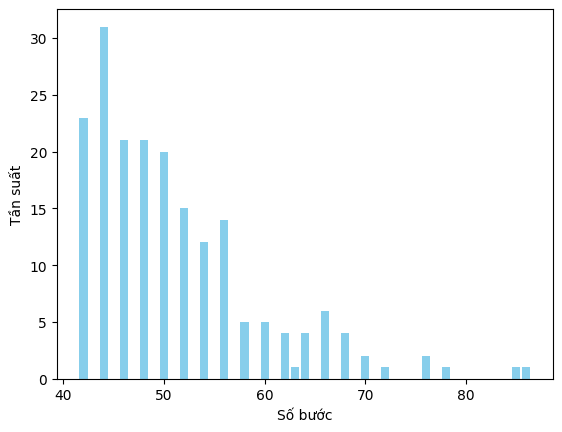

In [149]:
# Hiện biểu đồ thống kê
done_statistical = Counter(done_statistical)
done_values = list(done_statistical.keys())  # Các giá trị duy nhất
done_frequencies = list(done_statistical.values())

# Vẽ biểu đồ cột
plt.bar(done_values, done_frequencies, color="skyblue")

# Thêm nhãn và tiêu đề
plt.xlabel("Số bước")
plt.ylabel("Tần suất")
plt.title("")

# Hiển thị biểu đồ
plt.show()

In [150]:
# Cập nhật dữ liệu attention
save_attention_data = True
if save_attention_data:
    # Chuyển dữ liệu sang tensor
    training_keys = torch.tensor(training_keys, dtype=torch.float32).to(device)
    training_values = torch.tensor(training_values, dtype=torch.float32).to(device)
    training_relative_positions = torch.tensor(training_relative_positions, dtype=torch.float32).to(device)
    training_step_remainings = torch.tensor(training_step_remainings, dtype=torch.float32).to(device)
    new_attention_weight = max_episodes / len(values) * 0.25

    # Cập nhật dữ liệu attention
    for i in range(len(training_keys)):
        min_total_attention_weight = torch.argmin(total_attention_weight)
        
        if (new_attention_weight > total_attention_weight[min_total_attention_weight] or torch.sum(values[min_total_attention_weight]) == 0) and torch.sum(training_values[i] != 0):
            keys[min_total_attention_weight] = training_keys[i]
            values[min_total_attention_weight] = training_values[i]
            relative_positions[min_total_attention_weight] = training_relative_positions[i]
            step_remainings[min_total_attention_weight] = training_step_remainings[i]
            total_attention_weight[min_total_attention_weight] = max_episodes
            print(f"Updated attention weight: {min_total_attention_weight}")

save_model(policy_net, model_name + "/model.pth")

Updated attention weight: 39227
Updated attention weight: 42820
Updated attention weight: 31888
Updated attention weight: 3763
Updated attention weight: 13686
Updated attention weight: 34153
Updated attention weight: 13039
Updated attention weight: 27050
Updated attention weight: 43632
Updated attention weight: 45272
Updated attention weight: 33834
Updated attention weight: 4625
Updated attention weight: 23221
Updated attention weight: 6401
Updated attention weight: 15828
Updated attention weight: 1679
Updated attention weight: 28883
Updated attention weight: 3165
Updated attention weight: 33162
Updated attention weight: 30288
Updated attention weight: 12870
Updated attention weight: 43630
Updated attention weight: 3462
Updated attention weight: 14397
Updated attention weight: 48386
Updated attention weight: 19959
Updated attention weight: 26540
Updated attention weight: 8145
Updated attention weight: 18865
Updated attention weight: 49994
Updated attention weight: 9421
Updated attentio